In [10]:
import warnings; warnings.simplefilter('ignore')

from scipy.io import wavfile
import pandas as pd
import numpy as np
from plotnine import *

# Expanding your regressions repetoire with regularisation
*Classifying drum samples with logistic regression including feature selection*

## Introduction 
For many data scientists, the basic workhorse model is multiple linear regression. It serves as the first port of call in many analyses, and serves as the benchmark that more complicated models need to overcome. One of its strenghts is the easy interpretability of the resulting coefficients, something that especially neural networks struggle with. However, linear regression is not without its challenges. In this article we focus on one particular challenge: feature selection. 

Although selecting the features for the model can be done via expert knowledge, us data inclined people often use some kind of automated feature selection method. One example of such a method is stepwise regression, which is [generally regarded as a poor choice](https://towardsdatascience.com/stopping-stepwise-why-stepwise-selection-is-bad-and-what-you-should-use-instead-90818b3f52df). An alternative means of integrating feature selection into a regression algorithm is to use [regularisation](https://en.wikipedia.org/wiki/Regularization_(mathematics)). Regularistaion does this by expanding the normal least squares goal or loss function used in regression with a term which limits the size of coefficients. Limiting a coefficient to zero eliminates the feature from the model, effectively performing feature selection.  

In this article you will learn about the following topics:

- What regularisation is in more detail and why it is interesting to use
- What different types of regularisation there are
- How to practically use regularisation via a use case

## Why use regularisation?
- Normal regression intro
- loss function in regression
- why use regularisation? 

## Implementation of regularisation
- extend loss function using regularisation
- types of regularisation
- common methods that include regularisation (lasso, ridge, etc, etc)

## Example use of regularisation
### The Dataset

In [19]:
sample_rate, bass = wavfile.read('./sounds/bass1.wav')
bass_pd = pd.DataFrame(bass, columns=['left', 'right']).assign(time_id = range(len(bass)))
bass_pd.head()

,left,right,time_id
0,7,3,0
1,5,4,1
2,12,7,2
3,86,39,3
4,313,182,4


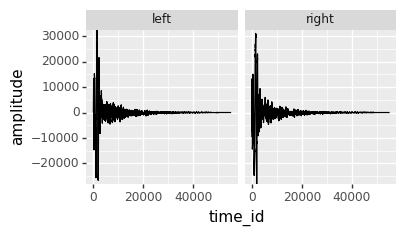

<ggplot: (8762920589433)>

In [17]:
(
    ggplot(bass_pd.melt(id_vars = ['time_id'], value_name='amplitude', var_name='stereo')) 
      + geom_line(aes(x = 'time_id', 
                      y = 'amplitude'))
      + facet_wrap('stereo') 
      + theme(figure_size=(4,2))
)

In [34]:
def audio_to_dataframe(path):
    from scipy.io import wavfile
    
    sample_rate, data = wavfile.read(path)
    ret_obj = (
        pd.DataFrame(data, columns=['left', 'right'])
          .assign(time_id = range(len(data)),
                  file_id = path)
    )
    return ret_obj

import glob

wav_files = glob.glob('sounds/kick/*.wav') + glob.glob('sounds/snare/*.wav') + glob.glob('sounds/tom/*.wav')
all_audio = pd.concat([audio_to_dataframe(path) for path in wav_files])
all_labels = pd.Series(np.repeat(['kick', 'snare', 'tom'], 25), 
                      index = wav_files)
all_audio.head()

,left,right,time_id,file_id
0,7,3,0,sounds/kick/Bass-Drum-1.wav
1,5,4,1,sounds/kick/Bass-Drum-1.wav
2,12,7,2,sounds/kick/Bass-Drum-1.wav
3,86,39,3,sounds/kick/Bass-Drum-1.wav
4,313,182,4,sounds/kick/Bass-Drum-1.wav


## Generating features

In [35]:
from tsfresh import extract_relevant_features
from tsfresh.feature_extraction import MinimalFCParameters
settings = MinimalFCParameters()

audio_tsfresh = extract_relevant_features(all_audio, all_labels, 
                                          column_id='file_id', column_sort='time_id', 
                                          default_fc_parameters=settings)

Feature Extraction: 100%|██████████| 10/10 [00:01<00:00,  7.44it/s]


In [37]:
audio_tsfresh.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75 entries, sounds/kick/Bass-Drum-1.wav to sounds/tom/Mid-Tom-2.wav
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left__standard_deviation   75 non-null     float64
 1   left__variance             75 non-null     float64
 2   right__standard_deviation  75 non-null     float64
 3   right__variance            75 non-null     float64
 4   right__sum_values          75 non-null     float64
 5   right__mean                75 non-null     float64
 6   left__mean                 75 non-null     float64
 7   left__sum_values           75 non-null     float64
 8   left__length               75 non-null     float64
 9   right__length              75 non-null     float64
 10  right__maximum             75 non-null     float64
dtypes: float64(11)
memory usage: 7.0+ KB


## Fitting Lasso

## The case for Lasso as a baseline model

Lasso goed:
- Snel
- Kan feature selectie doen iets meer fire and forget
- Feature selectie kan via cross-validatie
- Coef zijn nog interpreteerbaar, dit maakt het ook tot een goede data verkenningsmethode
- Vormt een mooie benchmark voor meer complexe methodes zoals Gradient Boosting Machines. 